# IMAGE DENOISING

### Librairies importation 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from skimage import data, img_as_float
from skimage.util import random_noise
from scipy import ndimage, signal
from skimage.filters import gaussian, median
from skimage.color import rgb2gray
from skimage import io, color, filters, util, restoration
from scipy.signal import wiener

# 1. SVD

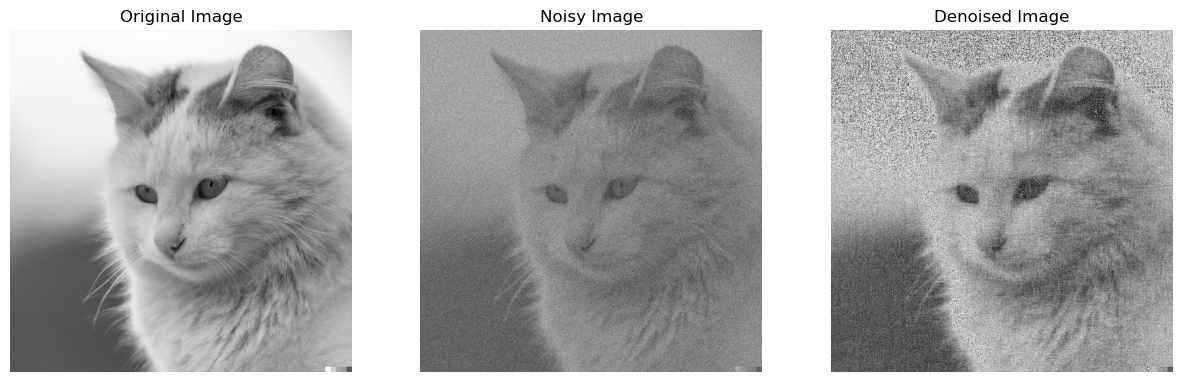

In [2]:
# Load the image
im = Image.open("Ol.png")
im = im.convert("L")  # Convert to grayscale
im = np.array(im)     # Convert to numpy array

# Add Gaussian noise to the image
noise = np.random.normal(0, 50, im.shape)
noisy_im = im + noise

# Perform SVD on the noisy image
U, S, Vt = np.linalg.svd(noisy_im)

# Determine the optimal rank to use in reconstruction
total_energy = np.sum(S**2)
energy_ratio = 0.95   # Set the desired energy retention ratio
current_energy = 0
for i in range(S.shape[0]):
    current_energy += S[i]**2
    if current_energy / total_energy >= energy_ratio:
        rank = i+1
        break

# Reconstruct the image using the optimal rank
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
reconstructed_im = U_ranked @ S_ranked @ Vt_ranked

# Convert the reconstructed image back to uint8 format
reconstructed_im = reconstructed_im.astype(np.uint8)

# Display the original, noisy, and denoised images side-by-side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(noisy_im, cmap='gray')
axs[1].set_title('Noisy Image')
axs[2].imshow(reconstructed_im, cmap='gray')
axs[2].set_title('Denoised Image')
for ax in axs:
    ax.axis('off')
plt.show()


# 2. Regularisation

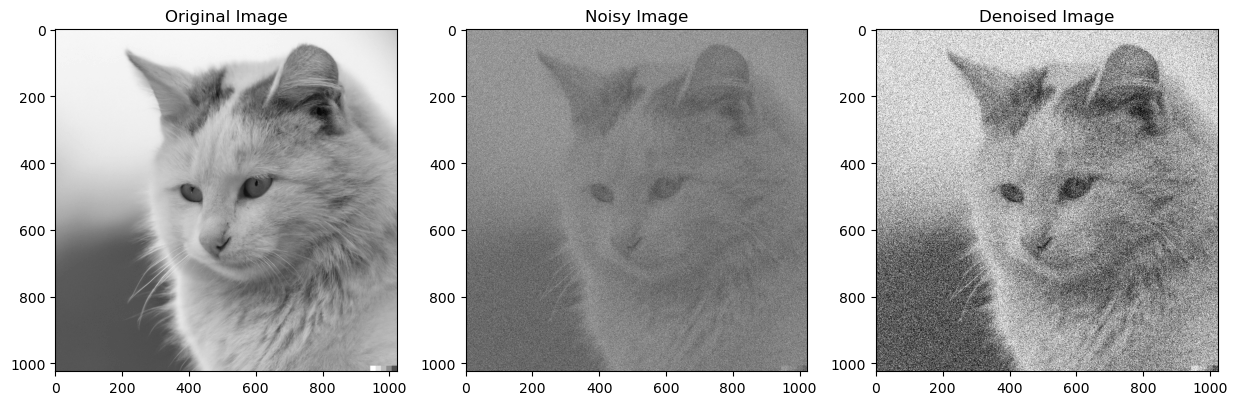

In [3]:
def denoise_image_reg(img, lmbda, alpha):
    # Convert image to grayscale
    img = color.rgb2gray(img)
    # Resize image to a square shape
    min_shape = min(img.shape)
    img_square = img[:min_shape, :min_shape]
    # Add noise to image
    img_noisy = img_square + alpha * np.random.randn(*img_square.shape)
    # Compute SVD of noisy image
    U, S, V = np.linalg.svd(img_noisy)
    # Compute denoised singular values
    S_denoised = np.maximum(S - lmbda, 0)
    # Reconstruct denoised image
    img_denoised = U.dot(np.diag(S_denoised)).dot(V)
    # Clip pixel values to [0, 1] range
    img_denoised = np.clip(img_denoised, 0, 1)
    return img, img_noisy, img_denoised

# Load Lena image
img = io.imread('Ol.png')

# Set regularization parameter
lmbda = 0.1

# Set noise level
alpha = 0.3

# Denoise image using regularization
img, img_noisy, img_denoised = denoise_image_reg(img, lmbda, alpha)

# Show original, noisy, and denoised images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
ax[2].imshow(img_denoised, cmap='gray')
ax[2].set_title('Denoised Image')
plt.show()

# 3. Filters

### 3.1 Gaussian Filter

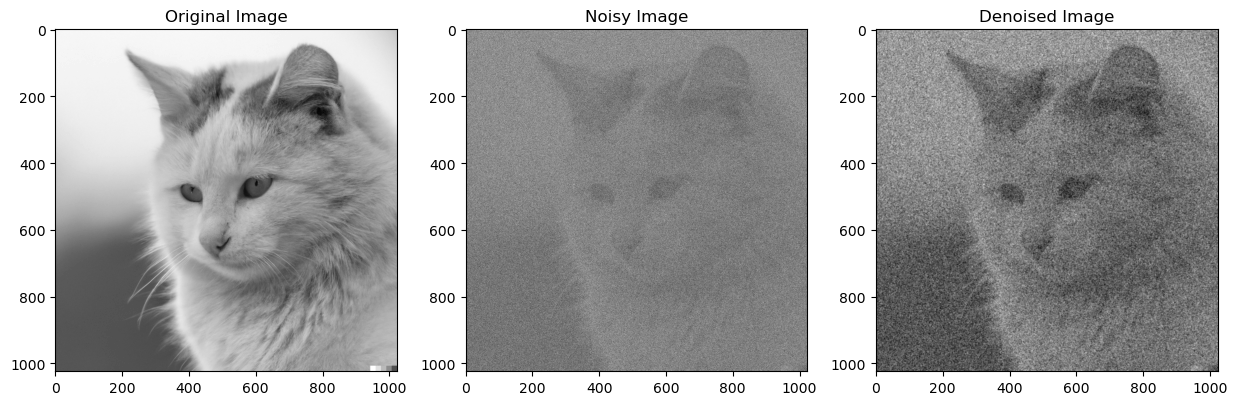

In [4]:
# Load image
img = io.imread('Ol.png')

# Convert image to grayscale
img_gray = color.rgb2gray(img)

# Add Gaussian noise to image
sigma = 0.6
img_noisy = img_gray + sigma * np.random.randn(*img_gray.shape)

# Denoise image using Gaussian filter
img_denoised = gaussian(img_noisy, sigma=1)

# Show original, noisy, and denoised images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
ax[2].imshow(img_denoised, cmap='gray')
ax[2].set_title('Denoised Image')
plt.show()


### 3.3 Median Filter

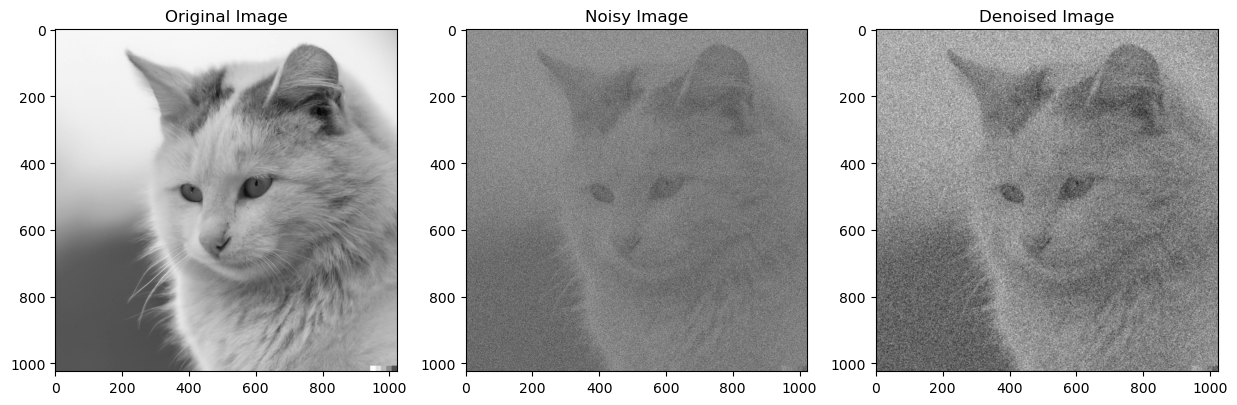

In [5]:
# Load image
img = io.imread('Ol.png')

# Convert image to grayscale
img_gray = color.rgb2gray(img)

# Add Gaussian noise to image
sigma = 0.4
img_noisy = img_gray + sigma * np.random.randn(*img_gray.shape)

# Denoise image using Median filter
img_denoised = ndimage.median_filter(img_noisy, footprint=np.ones((3, 3)))

# Show original, noisy, and denoised images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
ax[2].imshow(img_denoised, cmap='gray')
ax[2].set_title('Denoised Image')
plt.show()

In [6]:
# Save denoised image
io.imsave('denoised_image.jpg', img_denoised)

Lossy conversion from float64 to uint8. Range [-0.5093151949740741, 1.6420383932003213]. Convert image to uint8 prior to saving to suppress this warning.


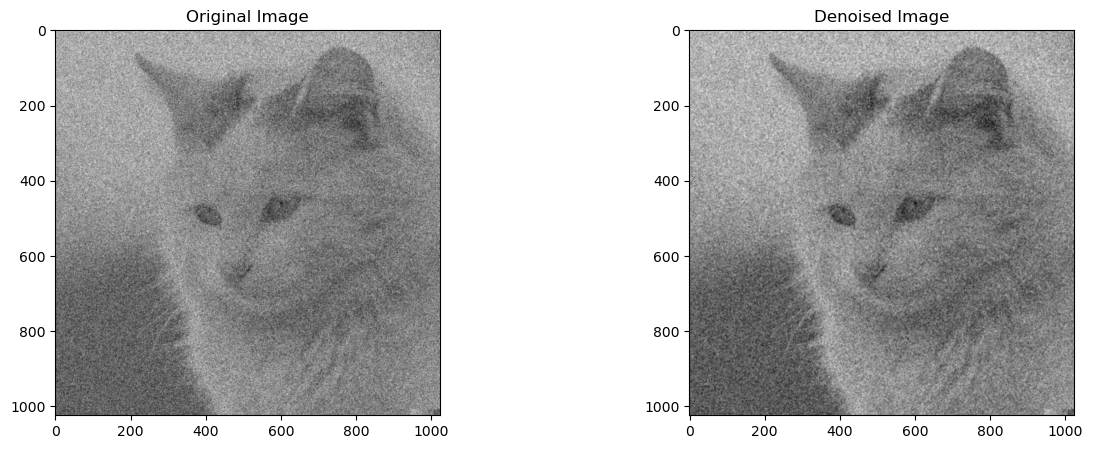

In [7]:
img_gray = io.imread('denoised_image.jpg')


# Denoise image using Median filter
img_denoised = ndimage.median_filter(img_gray, footprint=np.ones((3, 3)))

# Show original, noisy, and denoised images side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_denoised, cmap='gray')
ax[1].set_title('Denoised Image')
plt.show()

### 3.3 Wiener Filter

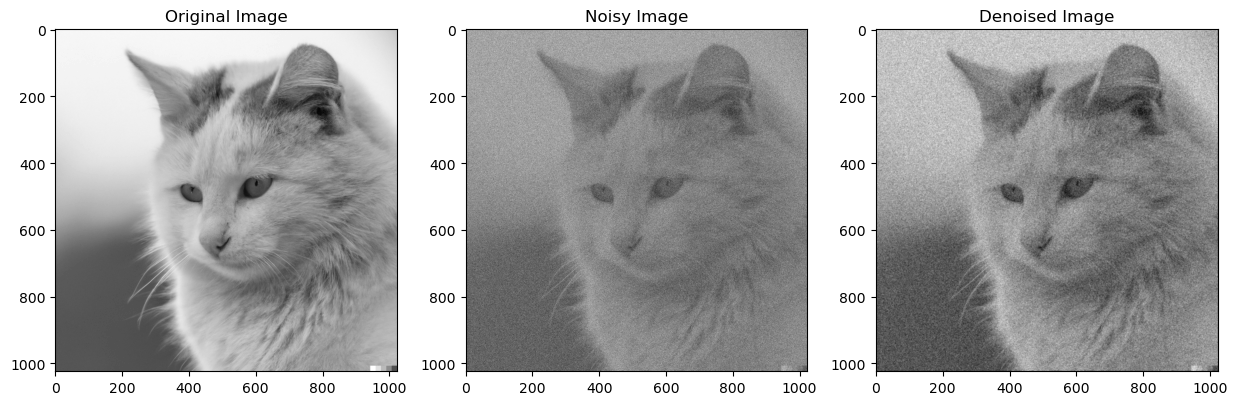

In [8]:
# Load image
img = io.imread('Ol.png')

# Convert image to grayscale
img_gray = color.rgb2gray(img)

# Add Gaussian noise to image
sigma = 0.2
img_noisy = img_gray + sigma * np.random.randn(*img_gray.shape)

# Denoise image using Wiener filter
img_denoised = wiener(img_noisy, mysize=3, noise=0.1)

# Show original, noisy, and denoised images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
ax[2].imshow(img_denoised, cmap='gray')
ax[2].set_title('Denoised Image')
plt.show()


# Image enhancement 

# 1.  Histogram equalization

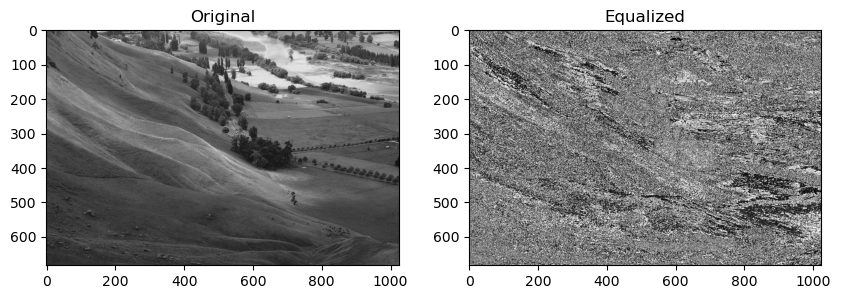

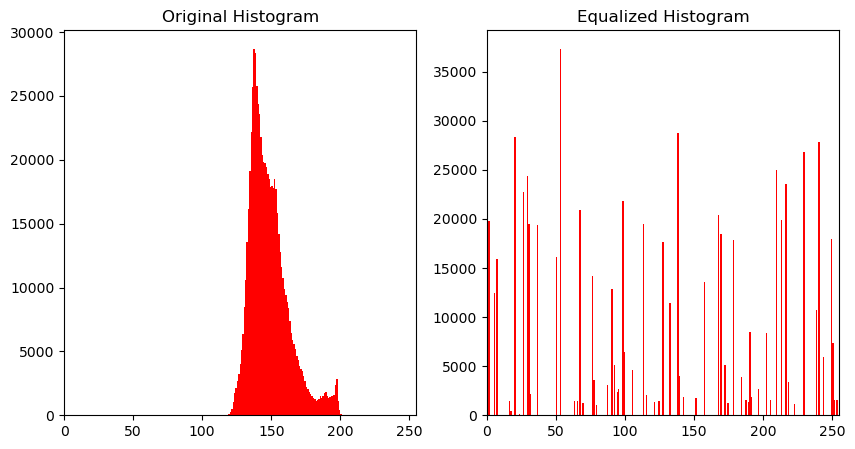

In [17]:
# Load image and convert to grayscale
img = Image.open('equalization.jpg').convert('L')
img_array = np.asarray(img)

# Calculate histogram
hist, bins = np.histogram(img_array.flatten(), 256, [0, 256])

# Calculate cumulative distribution function
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

# Create lookup table
lookup_table = np.interp(np.arange(256), bins[:-1], cdf_normalized)

# Apply lookup table to image
img_eq = np.interp(np.array(img_array), np.arange(256), lookup_table).astype('uint8')

# Calculate equalized histogram
hist_eq, _ = np.histogram(img_eq.flatten(), 256, [0, 256])

# Display original and equalized images using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(img_eq, cmap='gray')
axs[1].set_title('Equalized')

# Display histograms
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].hist(img_array.flatten(), bins=256, range=(0, 256), color='r')
axs[0].set_title('Original Histogram')
axs[0].set_xlim([0, 255])

axs[1].hist(img_eq.flatten(), bins=256, range=(0, 256), color='r')
axs[1].set_title('Equalized Histogram')
axs[1].set_xlim([0, 255])

plt.show()

# 2. Low pass filtering

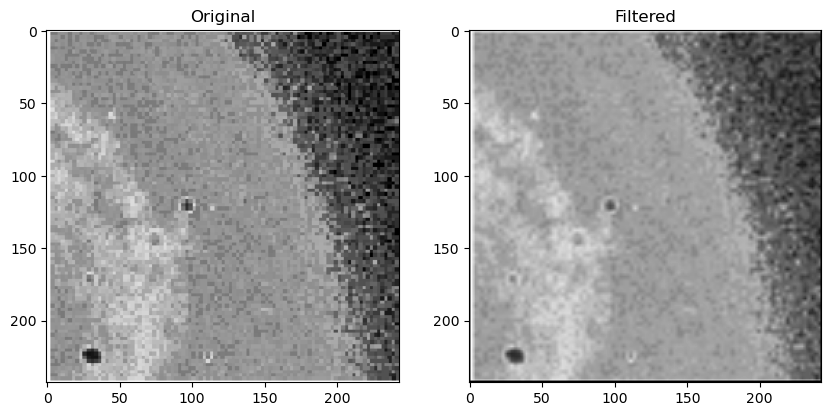

In [20]:
# Load image and convert to grayscale
img = Image.open('low_pass.png').convert('L')

# Convert image to numpy array
img_array = np.asarray(img)

# Define kernel for low pass filter
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]]) / 9

# Apply filter to image
filtered_img = np.zeros_like(img_array)
for i in range(1, img_array.shape[0]-1):
    for j in range(1, img_array.shape[1]-1):
        filtered_img[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * kernel)

# Display original and filtered images using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(filtered_img, cmap='gray')
axs[1].set_title('Filtered')

plt.show()


# High Pass Filtering

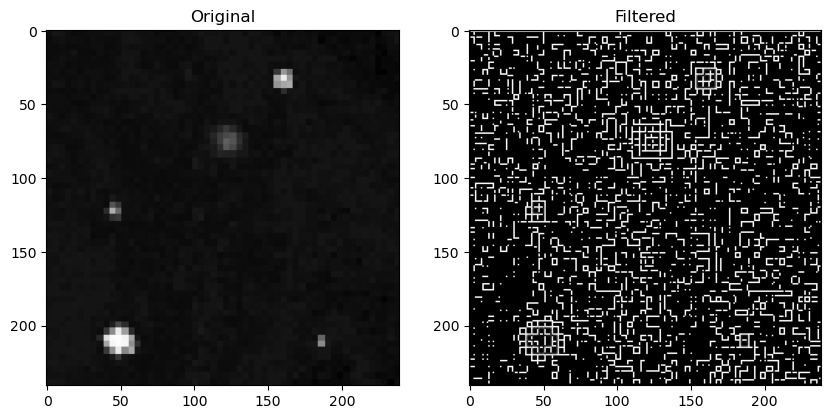

In [21]:
# Load image and convert to grayscale
img = Image.open('high_pass.png').convert('L')

# Convert image to numpy array
img_array = np.asarray(img)

# Define kernel for high pass filter
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]]) / 9

# Apply filter to image
filtered_img = np.zeros_like(img_array)
for i in range(1, img_array.shape[0]-1):
    for j in range(1, img_array.shape[1]-1):
        filtered_img[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * kernel)

# Display original and filtered images using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(filtered_img, cmap='gray')
axs[1].set_title('Filtered')

plt.show()


# Enhancement filters : Edge detection using Laplacian filter

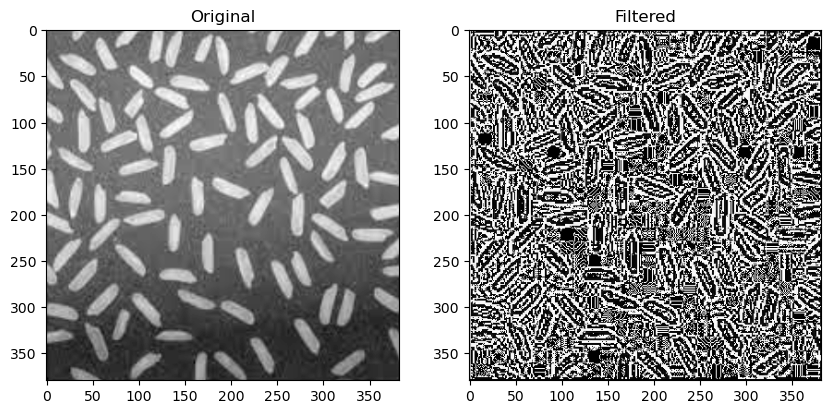

In [24]:
# Load image and convert to grayscale
img = Image.open('rice.png').convert('L')

# Convert image to numpy array
img_array = np.asarray(img)

# Define kernel for Laplacian filter
kernel = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])

# Apply filter to image
filtered_img = np.zeros_like(img_array)
for i in range(1, img_array.shape[0]-1):
    for j in range(1, img_array.shape[1]-1):
        filtered_img[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * kernel)

# Display original and filtered images using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(filtered_img, cmap='gray')
axs[1].set_title('Filtered')

plt.show()

# Color filters

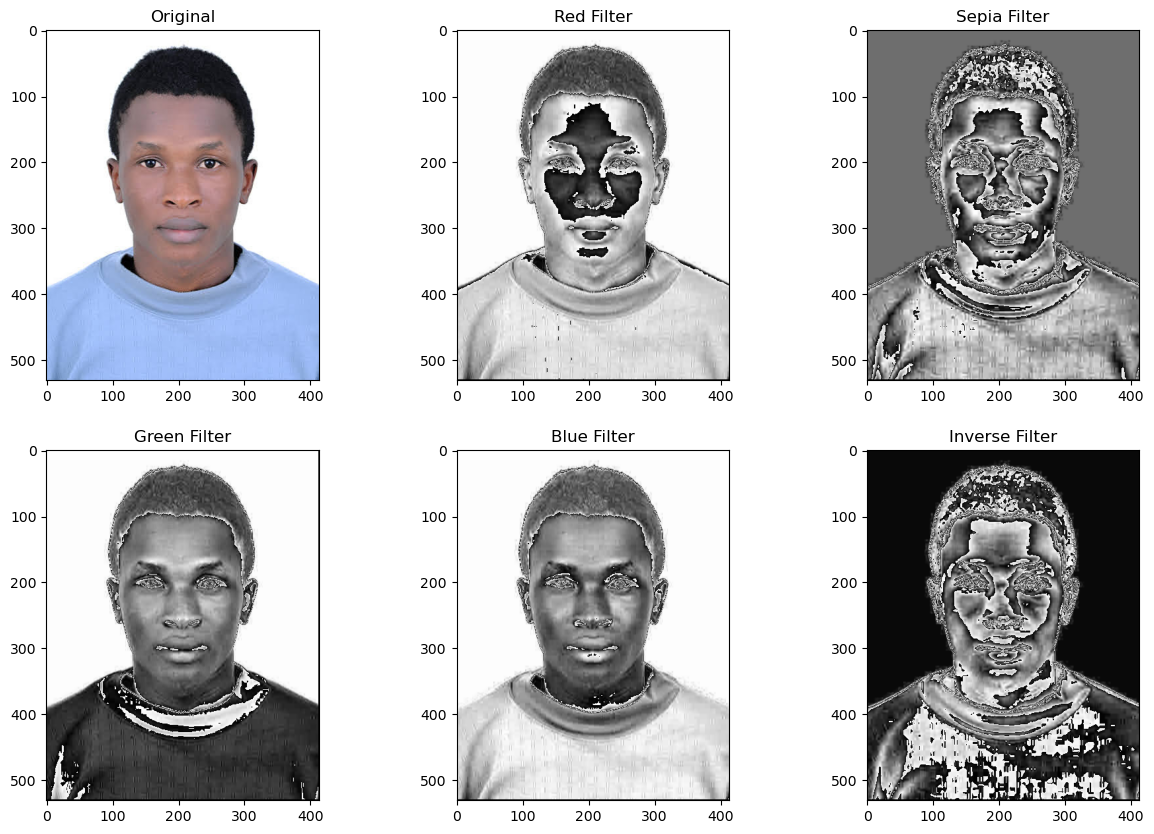

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load image
img = Image.open('Oli.jpg')

# Define color filter kernels
red_kernel = np.array([[1, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])

green_kernel = np.array([[0, 0, 0],
                         [0, 1, 0],
                         [0, 0, 0]])

blue_kernel = np.array([[0, 0, 0],
                        [0, 0, 0],
                        [0, 0, 1]])

sepia_kernel = np.array([[0.393, 0.769, 0.189],
                         [0.349, 0.686, 0.168],
                         [0.272, 0.534, 0.131]])

inverse_kernel = np.array([[-1, 0, 0],
                           [0, -1, 0],
                           [0, 0, -1]])

# Convert image to numpy array
img_array = np.asarray(img)

# Apply each color filter to image
filtered_red = np.zeros_like(img_array)
filtered_green = np.zeros_like(img_array)
filtered_blue = np.zeros_like(img_array)
filtered_sepia = np.zeros_like(img_array)
filtered_inverse = np.zeros_like(img_array)

for i in range(1, img_array.shape[0]-1):
    for j in range(1, img_array.shape[1]-1):
        filtered_red[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * red_kernel)
        filtered_green[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * green_kernel)
        filtered_blue[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * blue_kernel)
        filtered_sepia[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * sepia_kernel)
        filtered_inverse[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * inverse_kernel)

# Display original and filtered images using subplots
fig, axs = plt.subplots(2, 3, figsize=(15,10))

axs[0,0].imshow(img)
axs[0,0].set_title('Original')

axs[0,1].imshow(filtered_red, cmap='gray')
axs[0,1].set_title('Red Filter')

axs[0,2].imshow(filtered_sepia, cmap='gray')
axs[0,2].set_title('Sepia Filter')

axs[1,0].imshow(filtered_green, cmap='gray')
axs[1,0].set_title('Green Filter')

axs[1,1].imshow(filtered_blue, cmap='gray')
axs[1,1].set_title('Blue Filter')

axs[1,2].imshow(filtered_inverse, cmap='gray')
axs[1,2].set_title('Inverse Filter')

plt.show()

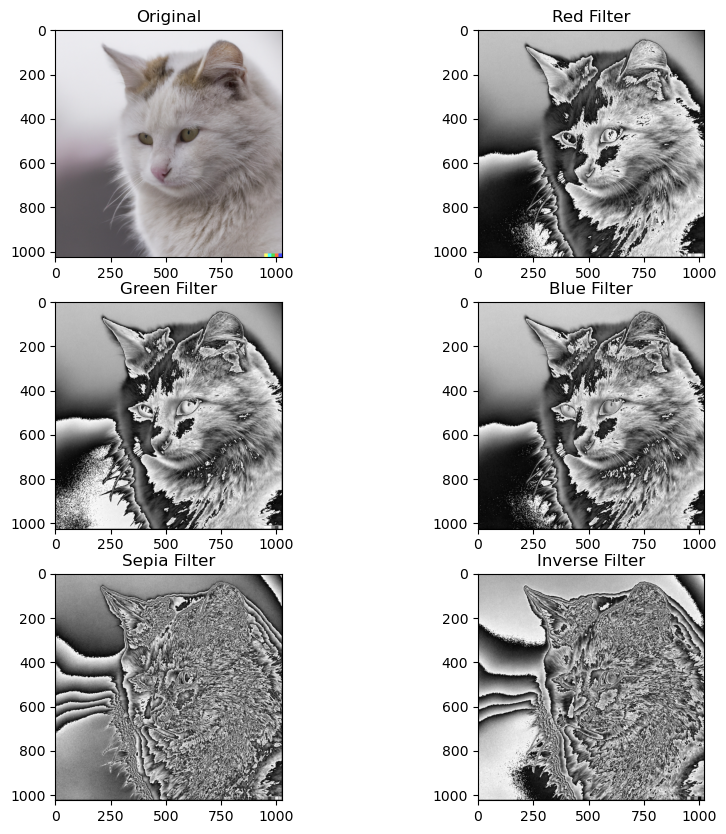

In [30]:
# Load image
img = Image.open('Ol.png')

# Define color filter kernels
red_kernel = np.array([[1, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])

green_kernel = np.array([[0, 0, 0],
                         [0, 1, 0],
                         [0, 0, 0]])

blue_kernel = np.array([[0, 0, 0],
                        [0, 0, 0],
                        [0, 0, 1]])

# Define sepia kernel
sepia_kernel = np.array([[0.393, 0.769, 0.189],
                         [0.349, 0.686, 0.168],
                         [0.272, 0.534, 0.131]])

# Define inverse kernel
inverse_kernel = np.array([[-1, 0, 0],
                           [0, -1, 0],
                           [0, 0, -1]])

# Convert image to numpy array
img_array = np.asarray(img)

# Apply each color filter to image
filtered_red = np.zeros_like(img_array)
filtered_green = np.zeros_like(img_array)
filtered_blue = np.zeros_like(img_array)
filtered_sepia = np.zeros_like(img_array)
filtered_inverse = np.zeros_like(img_array)

for i in range(1, img_array.shape[0]-1):
    for j in range(1, img_array.shape[1]-1):
        filtered_red[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * red_kernel)
        filtered_green[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * green_kernel)
        filtered_blue[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * blue_kernel)
        filtered_sepia[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * sepia_kernel)
        filtered_inverse[i,j] = np.sum(img_array[i-1:i+2,j-1:j+2] * inverse_kernel)

# Display original and filtered images using subplots
fig, axs = plt.subplots(3, 2, figsize=(10,10))

axs[0,0].imshow(img)
axs[0,0].set_title('Original')

axs[0,1].imshow(filtered_red, cmap='hot')
axs[0,1].set_title('Red Filter')

axs[1,0].imshow(filtered_green, cmap='hot')
axs[1,0].set_title('Green Filter')

axs[1,1].imshow(filtered_blue, cmap='hot')
axs[1,1].set_title('Blue Filter')

axs[2,0].imshow(filtered_sepia, cmap='hot')
axs[2,0].set_title('Sepia Filter')

axs[2,1].imshow(filtered_inverse, cmap='hot')
axs[2,1].set_title('Inverse Filter')

plt.show()